In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# Transform: convert to tensor & normalize (-1 to 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train + validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Load data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64)
test_loader  = DataLoader(test_data, batch_size=64)

print("✅ Data loaded successfully!")


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]

✅ Data loaded successfully!


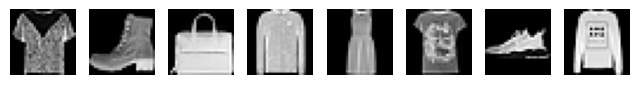

In [3]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(8,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


In [4]:
import torch.nn as nn

class FashionANN(nn.Module):
    def __init__(self):
        super(FashionANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 784)
        self.fc2 = nn.Linear(784, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

ann_model = FashionANN()
print(ann_model)

FashionANN(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer_ann = optim.Adam(ann_model.parameters(), lr=0.001)


In [6]:
epochs = 5
train_losses = []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer_ann.zero_grad()
        outputs = ann_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ann.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

print("✅ ANN training complete!")


Epoch [1/5], Loss: 0.5560
Epoch [2/5], Loss: 0.4014
Epoch [3/5], Loss: 0.3610
Epoch [4/5], Loss: 0.3273
Epoch [5/5], Loss: 0.3050
✅ ANN training complete!


In [7]:
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = ann_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy_ann = 100 * correct / total
print(f"🎯 ANN Test Accuracy: {accuracy_ann:.2f}%")


🎯 ANN Test Accuracy: 86.97%


In [8]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

cnn_model = FashionCNN()
print(cnn_model)


FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [9]:
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)


In [ ]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer_cnn.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("✅ CNN training complete!")


Epoch [1/10], Loss: 0.5191
Epoch [2/10], Loss: 0.3412
Epoch [3/10], Loss: 0.2932
Epoch [4/10], Loss: 0.2582
Epoch [5/10], Loss: 0.2323
Epoch [6/10], Loss: 0.2123
Epoch [7/10], Loss: 0.1932


In [ ]:
correct, total = 0, 0
all_preds_cnn, all_labels_cnn = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds_cnn.extend(predicted.numpy())
        all_labels_cnn.extend(labels.numpy())

accuracy_cnn = 100 * correct / total
print(f"🎯 CNN Test Accuracy: {accuracy_cnn:.2f}%")


In [ ]:
print(f"ANN Accuracy: {accuracy_ann:.2f}%")
print(f"CNN Accuracy: {accuracy_cnn:.2f}%")

if accuracy_cnn > accuracy_ann:
    print("✅ CNN performed better (as expected for image data).")
else:
    print("✅ ANN performed better (interesting result — check hyperparameters).")


In [ ]:
cm = confusion_matrix(all_labels_cnn, all_preds_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    "T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Boot"
])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()
